# Imports

In [1]:
using Pkg
# Pkg.add("PyCall")
# Pkg.build("PyCall")
# Pkg.add("Plots")
# Pkg.add("SciPy")
# # Pkg.add("Optim")
# # Pkg.add("Roots")
# # Pkg.add("QuadGK")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/6e47d11ea2776bc5627421d59cdcc1296c058071/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/1fc929f47d7c151c839c5fc1375929766fb8edcc/build.log`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [1]:
using PyCall
np = pyimport("numpy")
using SciPy
using Plots
# using Roots
# using QuadGK
# using Optim

In [9]:
# using Pkg
# Pkg.add("JuMP")
# Pkg.add("HiGHS")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed CodecBzip2 ───────── v0.7.2
   Installed BenchmarkTools ───── v1.3.1
   Installed MutableArithmetics ─ v1.0.4
   Installed MathOptInterface ─── v1.7.0
   Installed JuMP ─────────────── v1.2.0
    Updating `~/.julia/environments/v1.7/Project.toml`
  [4076af6c] + JuMP v1.2.0
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.3.1
  [523fee87] + CodecBzip2 v0.7.2
  [4076af6c] + JuMP v1.2.0
  [b8f27783] + MathOptInterface v1.7.0
  [d8a4904e] + MutableArithmetics v1.0.4
  [9abbd945] + Profile
Precompiling project...
  ✓ CodecBzip2
  ✓ BenchmarkTools
  ✓ MutableArithmetics
  ✓ MathOptInterface
  ✓ JuMP
  5 dependencies successfully precompiled in 53 seconds (251 already precompiled, 2 skipped during auto due to previous errors)
   Resolving package versions...
   Installed HiGHS_jll ─ v1.2.2+0
   Installed HiGHS ───── v1.1.4
    Updating `~/.julia/env

In [10]:
# using JuMP
# using HiGHS

# Function Testing

## Density Functions

In [2]:
function get_Rs(; kwargs...) 
    """
    Takes: None
    Args: None
    Kwargs: 
         Mass of black hole 'Mbh' in units [Msol]
    
    Returns: Schwartzchild radius for black hole of mass Mbh in units [kpc]
    """
    Mbh = kwargs[:Mbh]
    
    # conversion factors 
    kpc_to_pc = 1e-3
    
    G = 4.3e-3 * kpc_to_pc # units [kpc/Msol * (km/s)^2]
    c = 3e5 # units [km/s]
    Rs = 2*G*Mbh / c^2 
    
    return Rs
end

function rho_nfw(r; kwargs...)
    """
    Takes: 
        Radius 'r' in [kpc]
    Args: 
        rhos in units [g/cm^3]
        rs in [kpc] 
        (arxiv:1408.3534)
    Kwargs: None
    
    Returns: Dark matter NFW density at r [kpc] in units [GeV/cm^3]
    c=G=h=1 units
    """
    rhos, rs = kwargs[:rho0], kwargs[:a] 
    
    x = r./rs
    rho = rhos./ (x .* (1 .+ x).^2)

    return rho
end

function rho_spike(r; rsp=0.00054, kwargs...)
    """
    Takes: 
        Radius 'r' in [kpc]
    Args: 
        Mass of black hole 'Mbh' in units [Msol]
        alpha initial 'alpha_ini' dimensionless in range (0,2)
        radius of spike 'rsp' calculated numerically using rsp = 0.2*rh from arxiv:1408.3534
    Kwargs: None
    
    Returns: Dark matter NFW density at r [kpc] in units [GeV/cm^3]
    c=G=h=1 units
    """
    alpha_ini = kwargs[:alpha_ini]
    
    rhosp = rho_nfw(rsp; kwargs...)
    alpha = (9.0 .-(2.0 .*alpha_ini))/(4.0 .-alpha_ini)
    Rs = get_Rs(; kwargs...)
    g_alpha = (1 .- 4 .*(Rs ./ r)).^3

    rho = rhosp .* g_alpha .* (rsp ./ r).^alpha # [GeV/cm^3]

    return ifelse.(r .< rsp, rho, rho_nfw(r; kwargs...))
end

function get_rsp(; kwargs...)
    # use equation M(<rh) = int_0^rh 4pi rho_dm(r)r^2 = 2M_bh from arxiv:1408.3534
    Msol_to_GeV_cm2 = 1.11543e57
    g_cm3_to_GeV_cm3 = 2.938e64
    
    Mbh = kwargs[:Mbh]
    
    function f(rh)
        rsp = 0.2*rh
        I(r) = 4 * pi *(rho_spike(r; rsp=rsp, kwargs...) .* g_cm3_to_GeV_cm3) .* r.^2 
        LHS, err = SciPy.integrate.quad(I, 1e-8, rh) 
        RHS = 2 * Mbh .* Msol_to_GeV_cm2 
        return LHS .- RHS
    end
    
    rh = SciPy.optimize.newton(f, 1e-3)
    return 0.2*rh # rsp 
end

function rho_relativistic(r; kwargs...)
    """
    Takes: 
        Radius 'r' in [kpc]
    Args: 
        Mass of black hole 'Mbh' in units [Msol]
    Kwargs: 
        rho0 and a are scale paramters form arxiv:1408.3534
        alpha, beta, gamma and delta are scale fit parameters for Eq 7. from arXiv:2204.12508v1
        A, w, q, eta are fit parameters from Table 1. from arXiv:2204.12508v1
        
    
    Returns: Dark matter effective density in [GeV/cm^3] as a function of r, valid in the range
    r << a, a >= 0.01 kpc, or r << 0.01kpc
    c=G=h=1 units
    """
    # unit conversion 
    solar_mass_to_pc = 4.8e-14
    inv_pc2_to_GeV_cm3 = 7.934e14
    # Black hole mass
    Mbh = kwargs[:Mbh]
    # scale params
    rho0, a = kwargs[:rho0], kwargs[:a]
    # profile params
    alpha, beta, gamma, delta = kwargs[:alpha], kwargs[:beta], kwargs[:gamma], kwargs[:delta]
    # fit params 
    A, w, q, eta= kwargs[:A], kwargs[:w], kwargs[:q], kwargs[:eta]
   
    r *= 1e3 #[kpc to pc]
    A *= 1e-43 / (solar_mass_to_pc)^2 #[ Msol^-2] to [pc^-2]
    x_tilde = r / (Mbh * solar_mass_to_pc)
    
    rho_bar = A*(1.0 - 4.0 * (eta / x_tilde))^w *(4.17 * (1e11/x_tilde))^q
    
    rho = rho_bar*(10^delta)*((rho0/0.3)^alpha)*((Mbh/1e6)^beta)*((a/20.0)^gamma)
    
    rho*=inv_pc2_to_GeV_cm3

    return rho
end

rho_relativistic (generic function with 1 method)

## Dictionary

In [3]:
input_dict = Dict(
    :Mbh=>1e5, # [Msol] 
    :a=>0.0231, # [kpc],
    :rho0=> 3.8e-22 * 5.61e23, # [g/cm^3 to GeV/cm^3]  
    # NFW parameters
    :alpha=>0.331,
    :beta=>-1.66,
    :gamma=>0.32,
    :delta=>-0.000282,
    # NFW relativistic parameters
    :eta=>1,
    :A=>6.42,
    :w=>1.82,
    :q=>1.91,
    :alpha_ini=>1.0
)

Dict{Symbol, Real} with 12 entries:
  :alpha     => 0.331
  :rho0      => 213.18
  :gamma     => 0.32
  :delta     => -0.000282
  :w         => 1.82
  :eta       => 1
  :A         => 6.42
  :q         => 1.91
  :Mbh       => 100000.0
  :a         => 0.0231
  :beta      => -1.66
  :alpha_ini => 1.0

In [4]:
get_Rs(; input_dict...)

9.555555555555557e-12

In [5]:
rho_nfw(1; input_dict...)

0.0025104190868391043

In [6]:
rho_spike(1; input_dict...)

0.0025104190868391043

In [7]:
get_rsp(; input_dict...)

0.004790849026827609

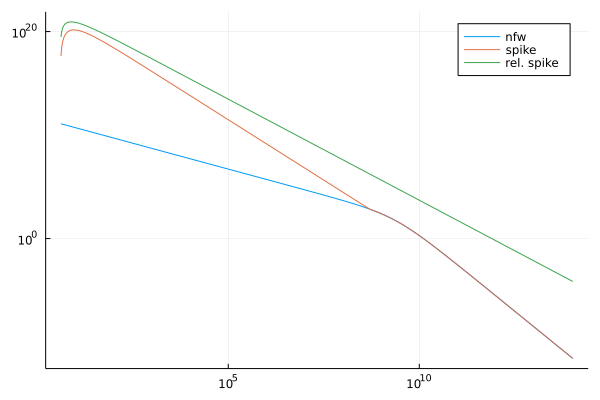

In [8]:
Rs = get_Rs(; input_dict...)
rsp = get_rsp(; input_dict...)
r = np.geomspace(4e-11,1e3,10000); 
r2 = np.geomspace(2e-11,1e3,10000)
rho = np.array([rho_nfw(r; input_dict...) for r in r]);
rho_s = np.array([rho_spike(r; rsp=rsp, input_dict...) for r in r])
rho_r = np.array([rho_relativistic(r; input_dict...) for r in r2])
plot(r/Rs, rho, xaxis=:log, yaxis=:log, label="nfw")
plot!(r/Rs, rho_s, xaxis=:log, yaxis=:log, label="spike")
plot!(r/Rs, rho_r, xaxis=:log, yaxis=:log, label="rel. spike")


In [9]:
r_isco = 6*4.8e-11

2.8800000000000004e-10

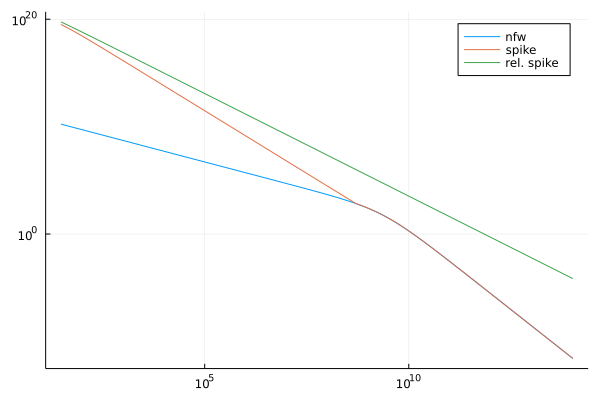

In [10]:
Rs = get_Rs(; input_dict...)
rsp = get_rsp(; input_dict...)
r = np.geomspace(r_isco,1e3,10000); 

rho = np.array([rho_nfw(r; input_dict...) for r in r]);
rho_s = np.array([rho_spike(r; rsp=rsp, input_dict...) for r in r])
rho_r = np.array([rho_relativistic(r; input_dict...) for r in r])
plot(r/Rs, rho, xaxis=:log, yaxis=:log, label="nfw")
plot!(r/Rs, rho_s, xaxis=:log, yaxis=:log, label="spike")
plot!(r/Rs, rho_r, xaxis=:log, yaxis=:log, label="rel. spike")